In [1]:
import os,sys,re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from itertools import product
#import pickle5 # Need pickle5 for DataFrame pickles
from scipy.stats import linregress,sem
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mue
import seaborn as sns
from natsort import natsorted as ns
from natsort import *
import matplotlib as mpl
import multiprocessing as mp
cpus = mp.cpu_count()

In [2]:
A8 = pd.read_pickle('../../data/EE/A8_RBFE.pkl')
A13 = pd.read_pickle('../../data/EE/A13_RBFE.pkl').fillna(0)
A18 = pd.read_pickle('../../data/EE/A18_RBFE.pkl')
A8_var = pd.read_pickle('../../data/EE/A8_variance.pkl')
A13_var = pd.read_pickle('../../data/EE/A13_variance.pkl').fillna(0)
A18_var = pd.read_pickle('../../data/EE/A18_variance.pkl')
on = False
if on:
    for col in A8.columns:
        A8[col] = np.mean(A8[col].values+np.random.randn(100000,len(A8[col]))*A8_var[col].values,axis=0)
    for col in A18.columns:
        A18[col] = np.mean(A18[col].values+np.random.randn(100000,len(A18[col]))*A18_var[col].values,axis=0)
    for col in A13.columns:
        A13[col] = np.mean(A13[col].values+np.random.randn(100000,len(A13[col]))*A13_var[col].values,axis=0)

A8_old = pd.read_pickle('../../data/old_EE/A8_RBFE.pkl').fillna(0)
A13_old = pd.read_pickle('../../data/old_EE/A13_RBFE.pkl').fillna(0)
A18_old = pd.read_pickle('../../data/old_EE/A18_RBFE.pkl').fillna(0)
old_A8_var = pd.read_pickle('../../data/old_EE/A8_variance.pkl').fillna(0)
old_A13_var = pd.read_pickle('../../data/old_EE/A13_variance.pkl').fillna(0)
old_A18_var = pd.read_pickle('../../data/old_EE/A18_variance.pkl').fillna(0)

#A8_exp = pd.read_csv('A8_initial_Log10Kd_estimates_20230913.csv')
A8_exp = pd.read_pickle('../../data/Experiment/A8_exp_dg.pkl').reindex(A8.index).fillna(0)
A8_exp_unc = pd.read_pickle('../../data/Experiment/A8_exp_unc.pkl').reindex(A8.index).fillna(0)
A8_seq = open('../../data/sequences/A8_sequence.afasta').readlines()[0].replace('\n','')
#A8_exp=transform_exp(A8_exp,A8_seq)
A8_seq =[f'{A8_seq[i]}{270+i}' for i in range(len(A8_seq))]


#A18_exp = pd.read_csv('A18_initial_Log10Kd_estimates_20230913.csv')
A18_exp = pd.read_pickle('../../data/Experiment/A18_exp_dg.pkl').reindex(A18.index).fillna(0)
A18_exp_unc = pd.read_pickle('../../data/Experiment/A18_exp_unc.pkl').reindex(A18.index).fillna(0)
A18_seq = open('../../data/sequences/A18_sequence.afasta').readlines()[0].replace('\n','')
#A18_exp=transform_exp(A18_exp,A18_seq)
A18_seq=[f'{A18_seq[i]}{270+i}' for i in range(len(A18_seq))]


#A13_exp = pd.read_csv('A13_initial_Log10Kd_estimates_20230913.csv')
A13_exp = pd.read_pickle('../../data/Experiment/A13_exp_dg.pkl').reindex(A13.index).fillna(0)
A13_exp_unc = pd.read_pickle('../../data/Experiment/A13_exp_unc.pkl').reindex(A13.index).fillna(0)
A13_seq = open('../../data/sequences/A13_sequence.afasta').readlines()[0].replace('\n','')
#A13_exp=transform_exp(A13_exp,A13_seq)
A13_seq =[f'{A13_seq[i]}{270+i}' for i in range(len(A13_seq))]

# Fix Rosetta A8 Df
A8_ros_pub = pd.read_csv('../../data/published_rosetta/norm_final_A8_rosetta.csv')
A8_ros_pub = A8_ros_pub.rename(columns={A8_ros_pub.columns[0]:''}) 
A8_ros_pub.set_index(A8_ros_pub.columns[0],inplace=True)
A8_ros_pub = A8_ros_pub

# Fix Rosetta A13 Df
A13_ros_pub = pd.read_csv('../../data/published_rosetta/norm_final_A13_rosetta.csv')
A13_ros_pub = A13_ros_pub.rename(columns={A13_ros_pub.columns[0]:''}) 
A13_ros_pub.set_index(A13_ros_pub.columns[0],inplace=True)
A13_ros_pub = A13_ros_pub

# Fix Rosetta A18 Df
A18_ros_pub = pd.read_csv('../../data/published_rosetta/norm_final_A18_rosetta.csv')
A18_ros_pub = A18_ros_pub.rename(columns={A18_ros_pub.columns[0]:''}) 
A18_ros_pub.set_index(A18_ros_pub.columns[0],inplace=True)
A18_ros_pub = A18_ros_pub

A8_curr_ros = pd.read_csv('../../data/current_rosetta/A8_current_rosetta.csv')
A13_curr_ros = pd.read_csv('../../data/current_rosetta/A13_current_rosetta.csv')
A18_curr_ros = pd.read_csv('../../data/current_rosetta/A18_current_rosetta.csv')


def make_df(output,temp):
    output = output[output['state']=='ddg']
    index = list(temp.index)
    columns = temp.columns
    array = np.zeros(shape=(len(index),len(columns)))
    temp = pd.DataFrame(array,index=index,columns=columns)
    for index,row in output.iterrows():
        _col = row['position_label']
        _mut = row['mutation'][-1]
        _val = row['total_score']
        temp[_col][_mut]+=_val
    return temp

A8_curr_ros = make_df(A8_curr_ros,A8_ros_pub.copy())
A13_curr_ros = make_df(A13_curr_ros,A13_ros_pub.copy())
A18_curr_ros = make_df(A18_curr_ros,A18_ros_pub.copy())

In [5]:
mean_A8 =      A8.mean(axis=0)
mean_A13 =     A13.mean(axis=0)
mean_A18 =     A18.mean(axis=0)
mean_A8_exp =  A8_exp[A8.columns].mean(axis=0)
mean_A13_exp = A13_exp[A13.columns].mean(axis=0)
mean_A18_exp = A18_exp[A18.columns].mean(axis=0)
mean_A8_ros =  A8_curr_ros[A8.columns].mean(axis=0)
mean_A13_ros = A13_curr_ros[A13.columns].mean(axis=0)
mean_A18_ros = A18_curr_ros[A18.columns].mean(axis=0)
mean_A8_ros2 =  A8_ros_pub[A8.columns].mean(axis=0)
mean_A13_ros2 = A13_ros_pub[A13.columns].mean(axis=0)
mean_A18_ros2 = A18_ros_pub[A18.columns].mean(axis=0)


In [6]:
std_A8 = A8.std(axis=0)
std_A13 = A13.std(axis=0)
std_A18 = A18.std(axis=0)
std_A8_exp = A8_exp[A8.columns].std(axis=0)
std_A13_exp = A13_exp[A13.columns].std(axis=0)
std_A18_exp = A18_exp[A18.columns].std(axis=0)
std_A8_ros = A8_curr_ros[A8.columns].std(axis=0)
std_A13_ros = A13_curr_ros[A13.columns].std(axis=0)
std_A18_ros = A18_curr_ros[A18.columns].std(axis=0)

In [7]:
beta=0.593**-1
x = np.concatenate([mean_A8_exp,mean_A13_exp,mean_A18_exp])
y1=np.clip(np.concatenate([mean_A8,mean_A13,mean_A18]),-5,6)
y2=np.concatenate([mean_A8_ros,mean_A13_ros,mean_A18_ros])
y3=-np.concatenate([mean_A8_ros2,mean_A13_ros2,mean_A18_ros2])

In [8]:
xerr = np.concatenate([std_A8_exp,std_A13_exp,std_A18_exp])
y1err=np.concatenate([std_A8,std_A13,std_A18])
y2err=np.concatenate([std_A8_ros,std_A13_ros,std_A18_ros])

In [9]:
def compute_95_conf(y):
    n = len(y)
    std_y = np.std(y)
    mean_y = np.mean(y)
    stderr = std_y / np.sqrt(n)
    margin_of_error = 1.96 * stderr
    ci_lower = mean_y - margin_of_error
    ci_upper = mean_y + margin_of_error
    return ci_upper, ci_lower

# Plot Average Residue Effects

/tmp/ipykernel_7022/1636852559.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Exp.','EE','Flex ddg'],fontsize=15)


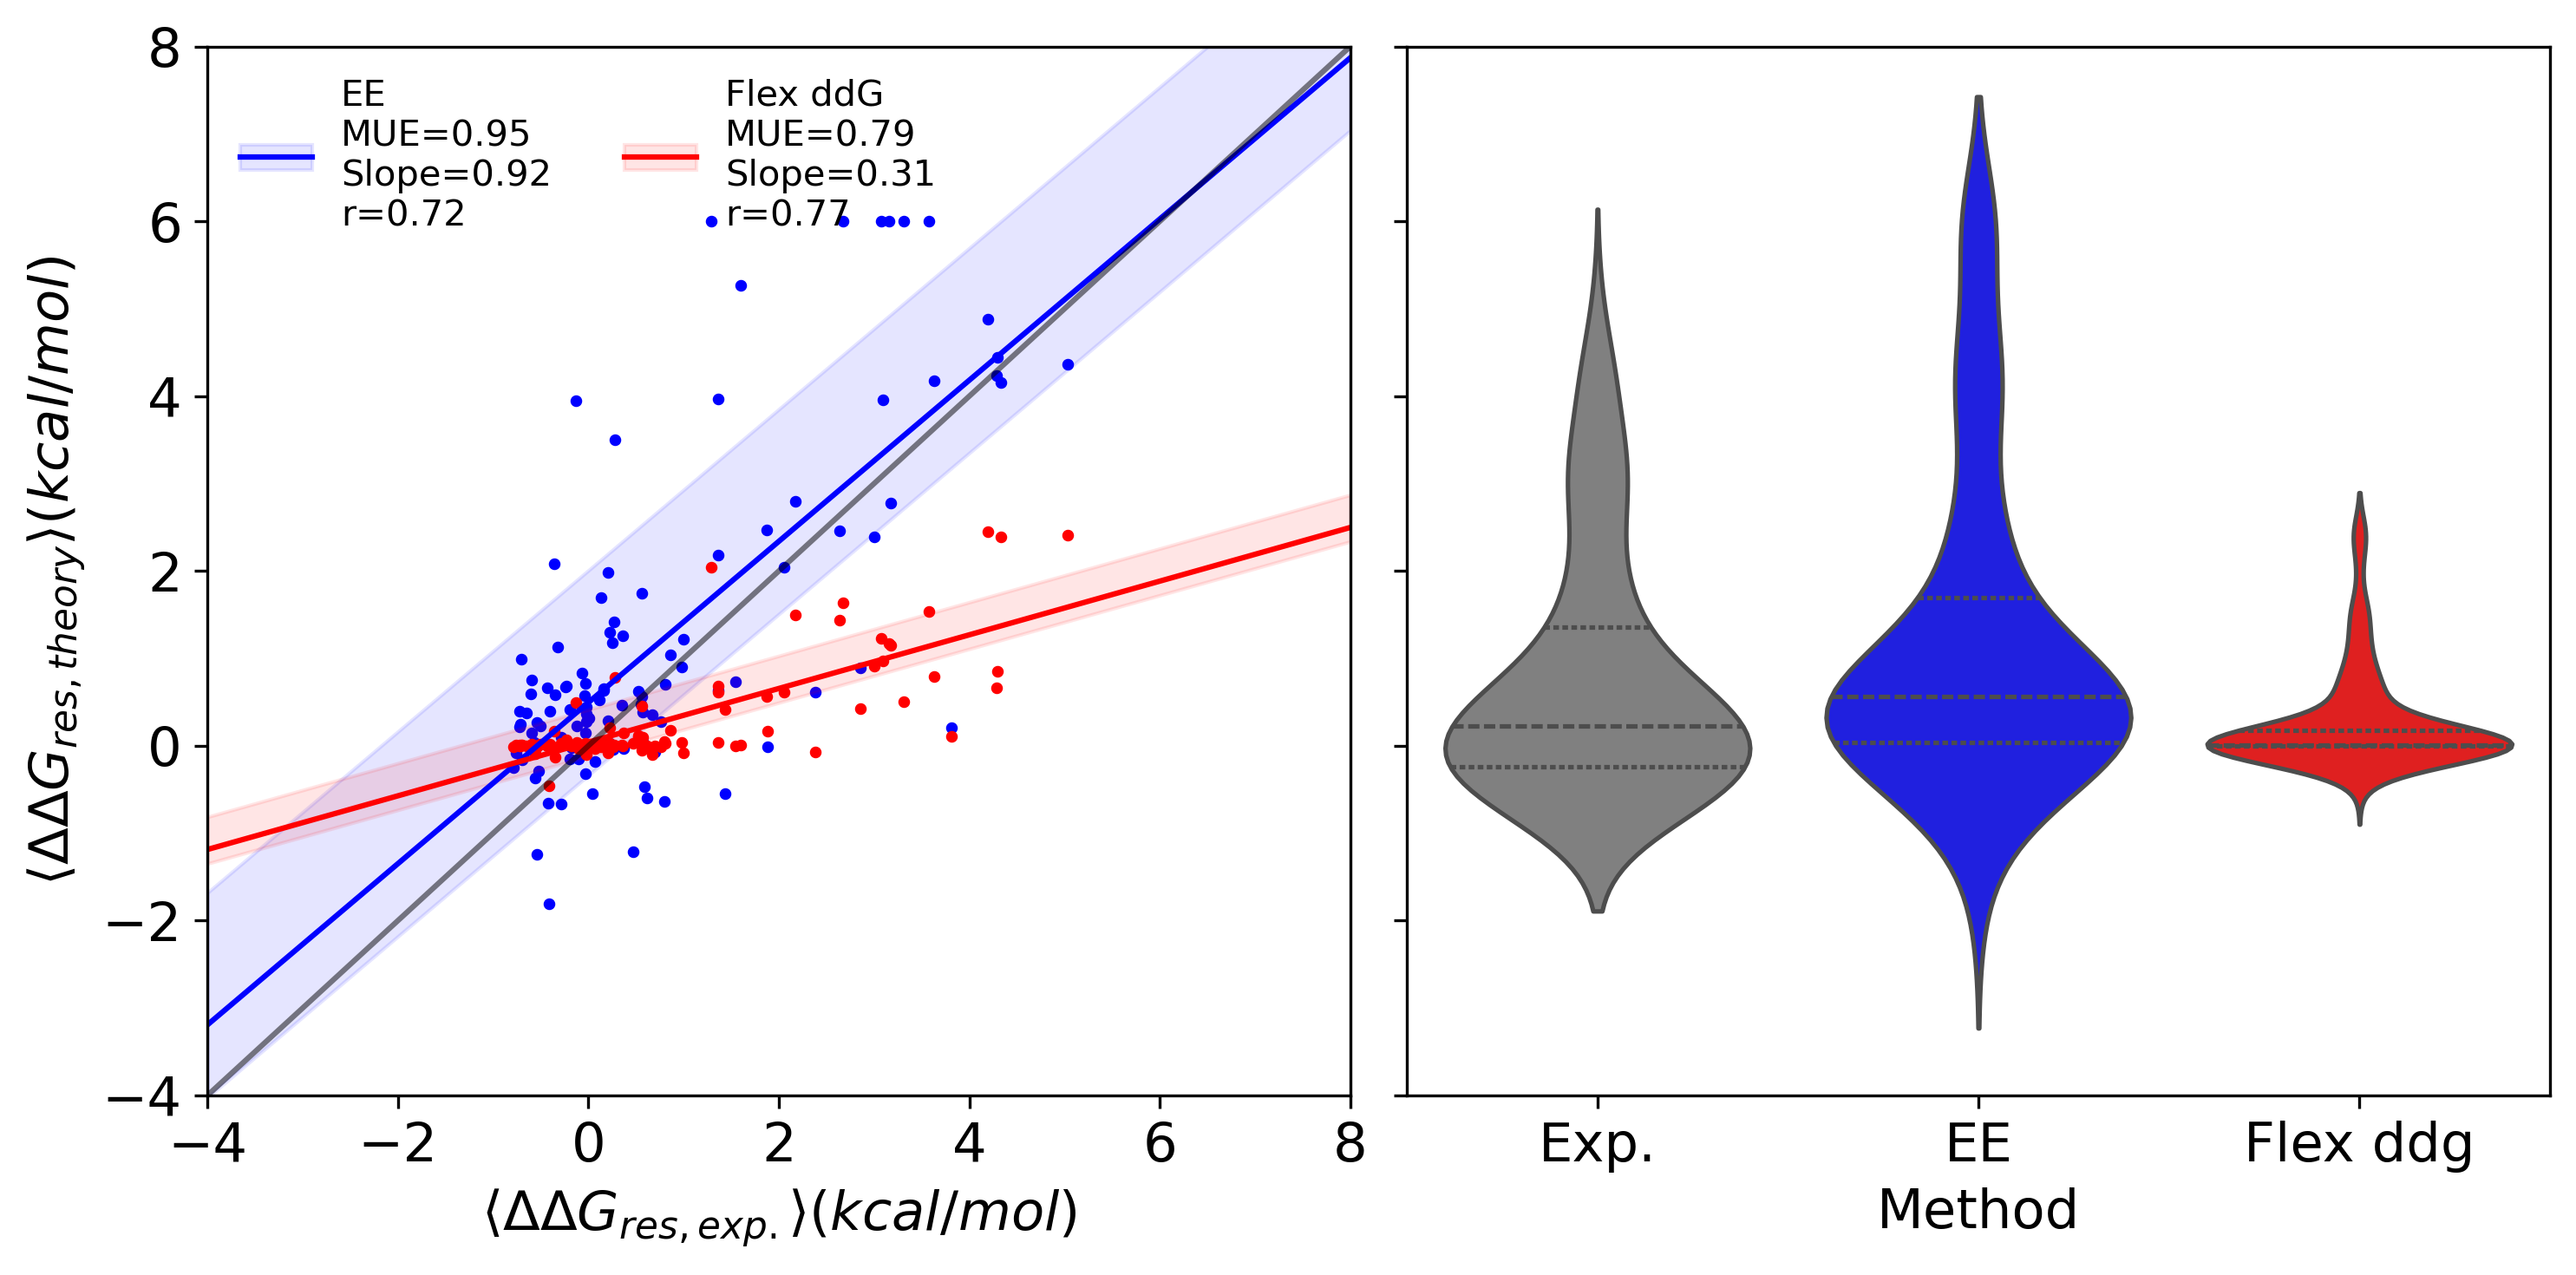

In [41]:
from matplotlib.legend_handler import HandlerTuple
from matplotlib.lines import Line2D
from matplotlib.patches import FancyBboxPatch,Patch
    
fig,axes = plt.subplots(1,2,figsize=(10,5),dpi=300,sharey=True)
l1 = linregress(x,y1)
MUE_fep = round(mue(x,y1),2)
l2 = linregress(x,y2)
MUE_ros = np.around(mue(x,y2),2)
l3 = linregress((x-np.mean(x))/np.std(x),y3)
MUE_ros2 = np.around(mue((x-np.mean(x))/np.std(x),y3),2)

xs = np.arange(-4,8.1,0.1)
pred_y1 = l1.slope*xs+l1.intercept
pred_y2 = l2.slope*xs+l2.intercept
#pred_y3 = l3.slope*xs+l3.intercept
ax=axes.flat[0]
line1,=ax.plot(xs,pred_y1,color='b')
line2,=ax.plot(xs,pred_y2,color='r')
label1=f'EE\nMUE={MUE_fep}\nSlope={l1.slope:.2f}\nr={l1.rvalue:.2f}'
label2=f'Flex ddG\nMUE={MUE_ros}\nSlope={l2.slope:.2f}\nr={l2.rvalue:.2f}'
ax.scatter(x,y1,color='b',s=5)

ci_h,ci_l = compute_95_conf(y1)
ax.fill_between(xs, pred_y1-ci_l, pred_y1+ci_h, color='b', alpha=0.1)
shade1=Patch(color='r',alpha=0.1,linewidth=0)

ax.scatter(x,y2,color='r',s=5)

ci_h,ci_l = compute_95_conf(y2)
ax.fill_between(xs, pred_y2-ci_l, pred_y2+ci_h, color='r', alpha=0.1)
shade2=Patch(color='r',alpha=0.1,linewidth=0)
"""
ax.scatter((x-np.mean(x))/np.std(x),y3,color='y',
        label=f'Chev.2017\nMUE={MUE_ros2}\nSlope={l3.slope:.2f}\nr={l3.rvalue:.2f}',s=5)
ax.plot(xs,pred_y3,color='y')
ci_h,ci_l = compute_95_conf(y3)
ax.fill_between(xs, pred_y3-ci_l, pred_y3+ci_h, color='y', alpha=0.1)
"""

ax.plot(np.arange(-4,10),np.arange(-4,10),c='k',alpha=0.5)
#ax.axvspan(-3,-1.2,ymax=0.3,alpha=0.2,color='grey')
ax.tick_params(axis='both',labelsize=15)
ax.set_xlabel(r'$\langle \Delta \Delta G_{res,exp.}\rangle(kcal/mol)$',fontsize=15)
ax.set_ylabel(r'$ \langle \Delta \Delta G_{res,theory} \rangle (kcal/mol)$',fontsize=15)
ax.set_xlim(-4,8)
ax.set_ylim(-4,8)
# Create combined handles for both lines and shaded areas
combined_handles = [
    (line1, Patch(color='b', alpha=0.1)),
    (line2, Patch(color='r', alpha=0.1))
]

# Add legend with combined handles
ax.legend(combined_handles, (label1,label2),ncol=2,loc='upper left',framealpha=0)

ax=axes.flat[1]
ax.tick_params(axis='both',labelsize=15)
sns.violinplot(x=0,y=x,ax=ax                ,inner='quart',color='grey')
sns.violinplot(x=1,y=np.clip(y1,-3,6),ax=ax ,inner='quart',color='blue')
sns.violinplot(x=2,y=y2,ax=ax               ,inner='quart',color='red')
"""
 # Melt the DataFrames to convert them to long-form
df1_long = pd.DataFrame(y3,columns=['value'])
df2_long = pd.DataFrame((x-np.mean(x))/np.std(x),columns=['value'])
#kl = calc_kl(df1_long.values,df2_long.values)
df1_long['Method'] = 'Chev.17'
df2_long['Method'] = 'Exp. Norm'
 
# Concatenate the two long-form DataFrames
merged_df = pd.concat([df1_long, df2_long])

sns.violinplot(data=merged_df,y='value', hue='Method',inner='quart',
               fill=True,split=True,gap=.1, ax=ax,palette={"Chev.17": "pink", "Exp. Norm": "yellow"})
"""
ax.set_xticklabels(['Exp.','EE','Flex ddg'],fontsize=15)
ax.set_xlabel('Method',fontsize=15)
#ax.set_ylabel('$\langle \Delta \Delta G_{res}\rangle(kcal/mol)$',fontsize=15)

fig.tight_layout()
fig.savefig('mean_res_mut_figure11.png',dpi=300,bbox_inches='tight')

# Write Average Effects to Files

In [442]:
def write_avg_effect_to_file(values,columns,out_file):
    numbers = [int(i[1:]) for i in columns]
    with open(out_file,'w') as f:
        for i,val in enumerate(values):
            num = numbers[i]
            string = f'{num} {val}\n'
            f.write(string)
            

In [444]:
l2w = [mean_A8_exp,mean_A13_exp,mean_A18_exp]+[mean_A8,mean_A13,mean_A18]+[mean_A8_ros,mean_A13_ros,mean_A18_ros]
names = ['A8_exp','A13_exp','A18_exp','A8_EE','A13_EE','A18_EE','A8_fddg','A13_fddg','A18_fddg']
res = {'A8':A8.columns.tolist(),'A13':A13.columns.tolist(),'A18':A18.columns.tolist()}
for i,data in enumerate(l2w):
    name = names[i]
    out_name = f'{name}_mean_effects.txt'
    mp = name.split('_')[0]
    residues = res[mp]
    write_avg_effect_to_file(data,residues,out_name)